In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

from torch.utils.data import Dataset, DataLoader

import numpy as np
from pathlib import Path
import os
import glob
from os import listdir
from os.path import isfile, join

from PIL import Image
import PIL

from skimage import io, color
#import splitfolders

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

E:\Anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#import cv2

In [3]:
import data_load
import model

In [4]:
mypath = "E:\\DeepLearning with pytorch\\PyTorch\Colorization\\output\\train\\Images\\"
train_paths = [mypath+f for f in listdir(mypath) if isfile(join(mypath, f))]

In [5]:
mypath1 = "E:\\DeepLearning with pytorch\\PyTorch\Colorization\\output\\val\\Images\\"
val_paths = [mypath1+f for f in listdir(mypath1) if isfile(join(mypath1, f))]

In [6]:
#Color_Dataset = Color_data_load.ColorizationDataset(path_list = train_paths)
Color_Dataset = data_load.ColorizationDataset(path_list = train_paths)
print('Length of dataset: ', len(Color_Dataset))

Length of dataset:  40000


In [7]:
def displaySampleShape(num_to_display):
    for i in range(num_to_display):
        rand_i = np.random.randint(0, len(Color_Dataset))
        sample = Color_Dataset[rand_i]

        print(i, sample['L'].shape, sample['image'].shape)
        #print(sample['image'].shape)
        
num_to_display = 3
#displaySampleShape(num_to_display)

In [8]:
data_transform = transforms.Compose([data_load.Normalize(), data_load.ToTensor()])

In [9]:
Color_Dataset = data_load.ColorizationDataset(path_list = train_paths, transform=data_transform)

In [10]:
gen = model.Generator()
#print(gen)

In [11]:
dics = model.Discriminator()
#print(dics)

In [12]:
#batch_size = 64

#train_loader = DataLoader(Color_Dataset, 
#                          batch_size=batch_size,
 #                         shuffle=True, 
  #                        num_workers=0)


In [13]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

True


device(type='cuda', index=0)

In [14]:
gen = model.Generator()

In [15]:
#batch_size = 64

#train_loader = DataLoader(Color_Dataset, 
                          #batch_size=batch_size,
                          #shuffle=True, 
                          #num_workers=0)


In [16]:
dics = model.Discriminator()


In [15]:
path = 'E:\\Photos\\'
train_paths = [path+f for f in listdir(path) if isfile(join(path, f))]

data_transform = transforms.Compose([data_load.Normalize(), data_load.ToTensor()])
Color_Dataset_train = data_load.ColorizationDataset(path_list = train_paths, transform=data_transform)


batch_size = 32

train_loader = DataLoader(Color_Dataset_train, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

print('Number of images: ', len(Color_Dataset_train))


Number of images:  5097


In [21]:
lrG = 0.0006
lrD = 0.00001


opt_dics = optim.Adam(dics.parameters(), lr = lrD)
opt_gen = optim.Adam(gen.parameters(), lr = lrG)

G_criterion = nn.BCELoss()

D_criterion = nn.BCELoss()

L1 = nn.L1Loss()

gen.to(device)
dics.to(device)

def train_net(n_epochs):

    # prepare the net for training
    gen.train()
    dics.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        for batch_i, data in enumerate(train_loader):

            L = data['L'].to(device)
            ab = data['ab']
            img = data['image'].to(device)
            #img = img.type(torch.FloatTensor)
            #L = L.type(torch.FloatTensor)

            
            ####    Train Dics   ####
            fake = gen(L)
            
            
            dics_real = dics(img)
            dics.zero_grad()
            dics_real = dics_real.view(-1)
            
            
            lossD_real = D_criterion(dics_real, torch.ones_like(dics_real))

        
            #complete_fake = []
            
            #for k in range(len(L)):
                #complete_fake.append(torch.concat((L[k], fake[k]), axis=0))
                
            
            #complete_fake = torch.stack(complete_fake)
        
            #dics_fake = dics(complete_fake.detach())
            dics_fake = dics(fake)
            dics_fake = dics_fake.view(-1)
            
            lossD_fake = D_criterion(dics_fake, torch.zeros_like(dics_fake))
            
            lossD = (lossD_real + lossD_fake) / 2 
            
            
            lossD.backward(retain_graph=True)
            
            opt_dics.step()
            
            
            ####  Train Gen  ####
            gen.zero_grad()
            
            output = dics(fake)

            output = output.view(-1)
            
            lossGAN = G_criterion(output, torch.ones_like(output))
            
            lossPix2Pix = L1(fake, img)
            
            lossG = lossGAN + lossPix2Pix
            
            
            lossG.backward()
            
            opt_gen.step()
            
            
            if batch_i % 10 == 9:    # print every 10 batches
                #print('Epoch: {}, Batch: {}, LossD: {}, LossGAN: {} , LossPix2Pix: {}, LossG: {}'.format(epoch + 1, batch_i+1, lossD, lossGAN, lossPix2Pix, lossG))
                print('Epoch: {}, batch: {}, LossD: {}, LossPix2Pix: {}, LossG: {}'.format(epoch + 1, batch_i + 1, lossD, lossPix2Pix, lossG))
    print('Finished Training')


In [22]:
torch.cuda.empty_cache()

In [23]:
# train your network
n_epochs = 170 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

E:\DeepLearning with pytorch\PyTorch\Colorization\data_load.py:105: RuntimeWarning: invalid value encountered in true_divide
  norm_imgage_copy = (imgage_copy - np.min(imgage_copy)) / (np.max(imgage_copy) - np.min(imgage_copy))
E:\DeepLearning with pytorch\PyTorch\Colorization\data_load.py:108: RuntimeWarning: invalid value encountered in true_divide
  norm_L_copy = (L_copy - np.min(L_copy)) / (np.max(L_copy) - np.min(L_copy))
E:\DeepLearning with pytorch\PyTorch\Colorization\data_load.py:111: RuntimeWarning: invalid value encountered in true_divide
  norm_ab_copy = (ab_copy - np.min(ab_copy)) / (np.max(ab_copy) - np.min(ab_copy))


Epoch: 1, batch: 10, LossD: 0.69704270362854, LossPix2Pix: 0.3384665846824646, LossG: 1.1319453716278076
Epoch: 1, batch: 20, LossD: 0.6907374858856201, LossPix2Pix: 0.2698926031589508, LossG: 1.0444039106369019
Epoch: 1, batch: 30, LossD: 0.6851544380187988, LossPix2Pix: 0.22909948229789734, LossG: 0.9853240251541138
Epoch: 1, batch: 40, LossD: 0.6933640241622925, LossPix2Pix: 0.19431072473526, LossG: 0.9160111546516418
Epoch: 1, batch: 50, LossD: 0.7004636526107788, LossPix2Pix: 0.19255366921424866, LossG: 0.8945927619934082
Epoch: 1, batch: 60, LossD: 0.7017440795898438, LossPix2Pix: 0.201344296336174, LossG: 0.8953193426132202
Epoch: 1, batch: 70, LossD: 0.6998156309127808, LossPix2Pix: 0.18959924578666687, LossG: 0.8903483152389526
Epoch: 1, batch: 80, LossD: 0.6845442652702332, LossPix2Pix: 0.18944162130355835, LossG: 0.898805558681488
Epoch: 1, batch: 90, LossD: 0.6962389945983887, LossPix2Pix: 0.18287454545497894, LossG: 0.9019627571105957
Epoch: 1, batch: 100, LossD: 0.6820600

Epoch: 5, batch: 140, LossD: 0.6953288912773132, LossPix2Pix: 0.1680494248867035, LossG: 0.8691771030426025
Epoch: 5, batch: 150, LossD: 0.703749418258667, LossPix2Pix: 0.16771070659160614, LossG: 0.8515986204147339
Epoch: 5, batch: 160, LossD: 0.6960384845733643, LossPix2Pix: 0.13564404845237732, LossG: 0.8363701105117798
Epoch: 6, batch: 10, LossD: 0.6961177587509155, LossPix2Pix: 0.18537819385528564, LossG: 0.8850523829460144
Epoch: 6, batch: 20, LossD: 0.6893651485443115, LossPix2Pix: 0.14637552201747894, LossG: 0.8453823328018188
Epoch: 6, batch: 30, LossD: 0.692380964756012, LossPix2Pix: 0.1683650016784668, LossG: 0.8687222003936768
Epoch: 6, batch: 40, LossD: 0.7025241851806641, LossPix2Pix: 0.15084290504455566, LossG: 0.8360867500305176
Epoch: 6, batch: 50, LossD: 0.6999853849411011, LossPix2Pix: 0.15524882078170776, LossG: 0.8522046804428101
Epoch: 6, batch: 60, LossD: 0.6918473839759827, LossPix2Pix: 0.15141472220420837, LossG: 0.8496110439300537
Epoch: 6, batch: 70, LossD: 0

Epoch: 10, batch: 100, LossD: 0.6906969547271729, LossPix2Pix: 0.15437549352645874, LossG: 0.8558829426765442
Epoch: 10, batch: 110, LossD: 0.6956818103790283, LossPix2Pix: 0.14787696301937103, LossG: 0.8468819856643677
Epoch: 10, batch: 120, LossD: 0.6897233724594116, LossPix2Pix: 0.1349673867225647, LossG: 0.844387412071228
Epoch: 10, batch: 130, LossD: 0.6827806234359741, LossPix2Pix: 0.14766326546669006, LossG: 0.8537148237228394
Epoch: 10, batch: 140, LossD: 0.7026633024215698, LossPix2Pix: 0.14031557738780975, LossG: 0.8269543647766113
Epoch: 10, batch: 150, LossD: 0.6994212865829468, LossPix2Pix: 0.1494889110326767, LossG: 0.8392876982688904
Epoch: 10, batch: 160, LossD: 0.6993988752365112, LossPix2Pix: 0.15429331362247467, LossG: 0.8691613078117371
Epoch: 11, batch: 10, LossD: 0.7008625268936157, LossPix2Pix: 0.14802046120166779, LossG: 0.8395552039146423
Epoch: 11, batch: 20, LossD: 0.696972131729126, LossPix2Pix: 0.14846697449684143, LossG: 0.8321946859359741
Epoch: 11, batch

Epoch: 15, batch: 60, LossD: 0.697645902633667, LossPix2Pix: 0.14691387116909027, LossG: 0.8407026529312134
Epoch: 15, batch: 70, LossD: 0.6939747333526611, LossPix2Pix: 0.16034340858459473, LossG: 0.8510775566101074
Epoch: 15, batch: 80, LossD: 0.6971694231033325, LossPix2Pix: 0.13873538374900818, LossG: 0.8367382287979126
Epoch: 15, batch: 90, LossD: 0.6930739283561707, LossPix2Pix: 0.14593768119812012, LossG: 0.8334816098213196
Epoch: 15, batch: 100, LossD: 0.6932557225227356, LossPix2Pix: 0.1372833251953125, LossG: 0.8274155855178833
Epoch: 15, batch: 110, LossD: 0.6947125792503357, LossPix2Pix: 0.13708750903606415, LossG: 0.8346876502037048
Epoch: 15, batch: 120, LossD: 0.6896759271621704, LossPix2Pix: 0.14105427265167236, LossG: 0.8513520359992981
Epoch: 15, batch: 130, LossD: 0.6901381015777588, LossPix2Pix: 0.14078977704048157, LossG: 0.8527847528457642
Epoch: 15, batch: 140, LossD: 0.6957118511199951, LossPix2Pix: 0.15366339683532715, LossG: 0.8573979139328003
Epoch: 15, batch

Epoch: 20, batch: 20, LossD: 0.6959002017974854, LossPix2Pix: 0.1462002396583557, LossG: 0.8399476408958435
Epoch: 20, batch: 30, LossD: 0.6907659769058228, LossPix2Pix: 0.14607255160808563, LossG: 0.838775634765625
Epoch: 20, batch: 40, LossD: 0.6947258114814758, LossPix2Pix: 0.13747936487197876, LossG: 0.8242023587226868
Epoch: 20, batch: 50, LossD: 0.6969523429870605, LossPix2Pix: 0.13737788796424866, LossG: 0.8233895301818848
Epoch: 20, batch: 60, LossD: 0.6952653527259827, LossPix2Pix: 0.13916021585464478, LossG: 0.823575496673584
Epoch: 20, batch: 70, LossD: 0.6943447589874268, LossPix2Pix: 0.15668261051177979, LossG: 0.8579024076461792
Epoch: 20, batch: 80, LossD: 0.6931098699569702, LossPix2Pix: 0.16634449362754822, LossG: 0.8628553152084351
Epoch: 20, batch: 90, LossD: 0.6986452341079712, LossPix2Pix: 0.14482241868972778, LossG: 0.8417954444885254
Epoch: 20, batch: 100, LossD: 0.6877748370170593, LossPix2Pix: 0.14803481101989746, LossG: 0.8565992116928101
Epoch: 20, batch: 110

Epoch: 24, batch: 140, LossD: 0.6786687970161438, LossPix2Pix: 0.1642303466796875, LossG: 0.8637742400169373
Epoch: 24, batch: 150, LossD: 0.6889299154281616, LossPix2Pix: 0.1441534012556076, LossG: 0.8277304768562317
Epoch: 24, batch: 160, LossD: 0.6903691291809082, LossPix2Pix: 0.14856736361980438, LossG: 0.8296109437942505
Epoch: 25, batch: 10, LossD: 0.698945164680481, LossPix2Pix: 0.14776048064231873, LossG: 0.8243087530136108
Epoch: 25, batch: 20, LossD: 0.6878983974456787, LossPix2Pix: 0.16296155750751495, LossG: 0.8566166758537292
Epoch: 25, batch: 30, LossD: 0.6896299123764038, LossPix2Pix: 0.13362586498260498, LossG: 0.8374109268188477
Epoch: 25, batch: 40, LossD: 0.6976081728935242, LossPix2Pix: 0.13511738181114197, LossG: 0.8351733684539795
Epoch: 25, batch: 50, LossD: 0.6979786157608032, LossPix2Pix: 0.14631116390228271, LossG: 0.8517881631851196
Epoch: 25, batch: 60, LossD: 0.700360119342804, LossPix2Pix: 0.145192950963974, LossG: 0.8355387449264526
Epoch: 25, batch: 70, 

Epoch: 29, batch: 100, LossD: 0.6905404925346375, LossPix2Pix: 0.13441206514835358, LossG: 0.8367137908935547
Epoch: 29, batch: 110, LossD: 0.6972545385360718, LossPix2Pix: 0.13628634810447693, LossG: 0.8352036476135254
Epoch: 29, batch: 120, LossD: 0.6877996325492859, LossPix2Pix: 0.13266167044639587, LossG: 0.8315334320068359
Epoch: 29, batch: 130, LossD: 0.7011619806289673, LossPix2Pix: 0.14272956550121307, LossG: 0.8347787261009216
Epoch: 29, batch: 140, LossD: 0.6925780177116394, LossPix2Pix: 0.14800971746444702, LossG: 0.8427836298942566
Epoch: 29, batch: 150, LossD: 0.6929731369018555, LossPix2Pix: 0.1412273496389389, LossG: 0.841874361038208
Epoch: 29, batch: 160, LossD: 0.6841213703155518, LossPix2Pix: 0.14638619124889374, LossG: 0.8510241508483887
Epoch: 30, batch: 10, LossD: 0.6941203474998474, LossPix2Pix: 0.14785809814929962, LossG: 0.8430249094963074
Epoch: 30, batch: 20, LossD: 0.6904181241989136, LossPix2Pix: 0.13441091775894165, LossG: 0.8244212865829468
Epoch: 30, bat

Epoch: 34, batch: 60, LossD: 0.7001542448997498, LossPix2Pix: 0.12491190433502197, LossG: 0.8202930688858032
Epoch: 34, batch: 70, LossD: 0.6977289319038391, LossPix2Pix: 0.12985935807228088, LossG: 0.8295905590057373
Epoch: 34, batch: 80, LossD: 0.6921783089637756, LossPix2Pix: 0.1341298669576645, LossG: 0.8409411311149597
Epoch: 34, batch: 90, LossD: 0.6953091621398926, LossPix2Pix: 0.14007532596588135, LossG: 0.8431849479675293
Epoch: 34, batch: 100, LossD: 0.6937826871871948, LossPix2Pix: 0.14642618596553802, LossG: 0.8523270487785339
Epoch: 34, batch: 110, LossD: 0.694365382194519, LossPix2Pix: 0.13425609469413757, LossG: 0.836593747138977
Epoch: 34, batch: 120, LossD: 0.6883629560470581, LossPix2Pix: 0.14345982670783997, LossG: 0.8445312976837158
Epoch: 34, batch: 130, LossD: 0.6923935413360596, LossPix2Pix: 0.1352560967206955, LossG: 0.8298178911209106
Epoch: 34, batch: 140, LossD: 0.6945059895515442, LossPix2Pix: 0.13550469279289246, LossG: 0.8311876058578491
Epoch: 34, batch: 

Epoch: 39, batch: 20, LossD: 0.6907106637954712, LossPix2Pix: 0.14605024456977844, LossG: 0.836398720741272
Epoch: 39, batch: 30, LossD: 0.6906907558441162, LossPix2Pix: 0.1426049768924713, LossG: 0.8271759748458862
Epoch: 39, batch: 40, LossD: 0.7003243565559387, LossPix2Pix: 0.14126801490783691, LossG: 0.8357812166213989
Epoch: 39, batch: 50, LossD: 0.6901811957359314, LossPix2Pix: 0.13364525139331818, LossG: 0.8448890447616577
Epoch: 39, batch: 60, LossD: 0.6925804615020752, LossPix2Pix: 0.12683600187301636, LossG: 0.8359318375587463
Epoch: 39, batch: 70, LossD: 0.691047191619873, LossPix2Pix: 0.13400498032569885, LossG: 0.833566427230835
Epoch: 39, batch: 80, LossD: 0.6947957277297974, LossPix2Pix: 0.14345112442970276, LossG: 0.8386983871459961
Epoch: 39, batch: 90, LossD: 0.6965611577033997, LossPix2Pix: 0.12876950204372406, LossG: 0.8213673233985901
Epoch: 39, batch: 100, LossD: 0.6908036470413208, LossPix2Pix: 0.13870655000209808, LossG: 0.8240762948989868
Epoch: 39, batch: 110,

Epoch: 43, batch: 140, LossD: 0.6956150531768799, LossPix2Pix: 0.1396234631538391, LossG: 0.8381009697914124
Epoch: 43, batch: 150, LossD: 0.688086748123169, LossPix2Pix: 0.14861249923706055, LossG: 0.8453075885772705
Epoch: 43, batch: 160, LossD: 0.7015472650527954, LossPix2Pix: 0.1568940132856369, LossG: 0.8660603761672974
Epoch: 44, batch: 10, LossD: 0.6886783838272095, LossPix2Pix: 0.13011310994625092, LossG: 0.8389259576797485
Epoch: 44, batch: 20, LossD: 0.6977149248123169, LossPix2Pix: 0.12788155674934387, LossG: 0.8407831192016602
Epoch: 44, batch: 30, LossD: 0.6912549734115601, LossPix2Pix: 0.14924538135528564, LossG: 0.8559571504592896
Epoch: 44, batch: 40, LossD: 0.6902973055839539, LossPix2Pix: 0.1450037956237793, LossG: 0.8457561135292053
Epoch: 44, batch: 50, LossD: 0.6918129920959473, LossPix2Pix: 0.14750996232032776, LossG: 0.8384749889373779
Epoch: 44, batch: 60, LossD: 0.6892904043197632, LossPix2Pix: 0.1270090937614441, LossG: 0.8285462260246277
Epoch: 44, batch: 70,

Epoch: 48, batch: 100, LossD: 0.6886681318283081, LossPix2Pix: 0.12941887974739075, LossG: 0.836713433265686
Epoch: 48, batch: 110, LossD: 0.6911069750785828, LossPix2Pix: 0.12894129753112793, LossG: 0.8216816782951355
Epoch: 48, batch: 120, LossD: 0.6944669485092163, LossPix2Pix: 0.14273115992546082, LossG: 0.8287832736968994
Epoch: 48, batch: 130, LossD: 0.6940388083457947, LossPix2Pix: 0.1430380642414093, LossG: 0.8361347913742065
Epoch: 48, batch: 140, LossD: 0.6948675513267517, LossPix2Pix: 0.13817904889583588, LossG: 0.8411905169487
Epoch: 48, batch: 150, LossD: 0.693444013595581, LossPix2Pix: 0.12334834039211273, LossG: 0.8227015733718872
Epoch: 48, batch: 160, LossD: 0.6884946823120117, LossPix2Pix: 0.13100048899650574, LossG: 0.8379595279693604
Epoch: 49, batch: 10, LossD: 0.6825771927833557, LossPix2Pix: 0.1403311789035797, LossG: 0.8434197902679443
Epoch: 49, batch: 20, LossD: 0.7005053162574768, LossPix2Pix: 0.14588259160518646, LossG: 0.8332911729812622
Epoch: 49, batch: 3

Epoch: 53, batch: 60, LossD: 0.6888658404350281, LossPix2Pix: 0.12804092466831207, LossG: 0.8360398411750793
Epoch: 53, batch: 70, LossD: 0.693247377872467, LossPix2Pix: 0.12649360299110413, LossG: 0.8284338712692261
Epoch: 53, batch: 80, LossD: 0.695344090461731, LossPix2Pix: 0.13389182090759277, LossG: 0.827738881111145
Epoch: 53, batch: 90, LossD: 0.690116286277771, LossPix2Pix: 0.12566374242305756, LossG: 0.8150439858436584
Epoch: 53, batch: 100, LossD: 0.6901795864105225, LossPix2Pix: 0.13588669896125793, LossG: 0.8252544403076172
Epoch: 53, batch: 110, LossD: 0.6922996044158936, LossPix2Pix: 0.13054348528385162, LossG: 0.8278434872627258
Epoch: 53, batch: 120, LossD: 0.6847048401832581, LossPix2Pix: 0.14638829231262207, LossG: 0.8464011549949646
Epoch: 53, batch: 130, LossD: 0.6837133765220642, LossPix2Pix: 0.14888235926628113, LossG: 0.8500525951385498
Epoch: 53, batch: 140, LossD: 0.6958409547805786, LossPix2Pix: 0.13103079795837402, LossG: 0.8343678712844849
Epoch: 53, batch: 

Epoch: 58, batch: 20, LossD: 0.6976423263549805, LossPix2Pix: 0.12156742811203003, LossG: 0.816851794719696
Epoch: 58, batch: 30, LossD: 0.6876553297042847, LossPix2Pix: 0.13363921642303467, LossG: 0.8295690417289734
Epoch: 58, batch: 40, LossD: 0.6917588710784912, LossPix2Pix: 0.13432738184928894, LossG: 0.8317008018493652
Epoch: 58, batch: 50, LossD: 0.6883227825164795, LossPix2Pix: 0.1502200961112976, LossG: 0.8494166731834412
Epoch: 58, batch: 60, LossD: 0.689405083656311, LossPix2Pix: 0.11377424001693726, LossG: 0.8196790218353271
Epoch: 58, batch: 70, LossD: 0.694305956363678, LossPix2Pix: 0.12335358560085297, LossG: 0.8245636224746704
Epoch: 58, batch: 80, LossD: 0.6828598380088806, LossPix2Pix: 0.12891337275505066, LossG: 0.8163492679595947
Epoch: 58, batch: 90, LossD: 0.6935802698135376, LossPix2Pix: 0.12970656156539917, LossG: 0.8276230096817017
Epoch: 58, batch: 100, LossD: 0.6914629340171814, LossPix2Pix: 0.12143582105636597, LossG: 0.8270602822303772
Epoch: 58, batch: 110,

Epoch: 62, batch: 140, LossD: 0.691093921661377, LossPix2Pix: 0.11951114982366562, LossG: 0.8155152797698975
Epoch: 62, batch: 150, LossD: 0.687584400177002, LossPix2Pix: 0.1126980409026146, LossG: 0.8133629560470581
Epoch: 62, batch: 160, LossD: 0.6948056817054749, LossPix2Pix: 0.13123290240764618, LossG: 0.8350891470909119
Epoch: 63, batch: 10, LossD: 0.6907758116722107, LossPix2Pix: 0.11600663512945175, LossG: 0.8226606249809265
Epoch: 63, batch: 20, LossD: 0.6899045705795288, LossPix2Pix: 0.11829708516597748, LossG: 0.8227607607841492
Epoch: 63, batch: 30, LossD: 0.6850069761276245, LossPix2Pix: 0.12846867740154266, LossG: 0.8305859565734863
Epoch: 63, batch: 40, LossD: 0.6910492777824402, LossPix2Pix: 0.11015120148658752, LossG: 0.8071736097335815
Epoch: 63, batch: 50, LossD: 0.6935261487960815, LossPix2Pix: 0.134187713265419, LossG: 0.825777530670166
Epoch: 63, batch: 60, LossD: 0.6911919713020325, LossPix2Pix: 0.1151716336607933, LossG: 0.7937917113304138
Epoch: 63, batch: 70, L

Epoch: 67, batch: 100, LossD: 0.6996509432792664, LossPix2Pix: 0.11944682896137238, LossG: 0.8045902848243713
Epoch: 67, batch: 110, LossD: 0.6995657086372375, LossPix2Pix: 0.10583880543708801, LossG: 0.7931448221206665
Epoch: 67, batch: 120, LossD: 0.6956300735473633, LossPix2Pix: 0.11406060308218002, LossG: 0.8107386231422424
Epoch: 67, batch: 130, LossD: 0.6893331408500671, LossPix2Pix: 0.12207850068807602, LossG: 0.8234440684318542
Epoch: 67, batch: 140, LossD: 0.6956211924552917, LossPix2Pix: 0.10483597218990326, LossG: 0.8020722270011902
Epoch: 67, batch: 150, LossD: 0.6912381052970886, LossPix2Pix: 0.12295466661453247, LossG: 0.8186224102973938
Epoch: 67, batch: 160, LossD: 0.6907813549041748, LossPix2Pix: 0.1391609162092209, LossG: 0.8505579829216003
Epoch: 68, batch: 10, LossD: 0.6861426830291748, LossPix2Pix: 0.11296120285987854, LossG: 0.8165816068649292
Epoch: 68, batch: 20, LossD: 0.6934840679168701, LossPix2Pix: 0.13074831664562225, LossG: 0.8322733044624329
Epoch: 68, ba

Epoch: 72, batch: 60, LossD: 0.6862047910690308, LossPix2Pix: 0.11427874863147736, LossG: 0.8143033385276794
Epoch: 72, batch: 70, LossD: 0.692923903465271, LossPix2Pix: 0.10743158310651779, LossG: 0.7998385429382324
Epoch: 72, batch: 80, LossD: 0.6950373649597168, LossPix2Pix: 0.11785374581813812, LossG: 0.8110655546188354
Epoch: 72, batch: 90, LossD: 0.689816951751709, LossPix2Pix: 0.10097494721412659, LossG: 0.8025496006011963
Epoch: 72, batch: 100, LossD: 0.6967428922653198, LossPix2Pix: 0.0953046903014183, LossG: 0.7942651510238647
Epoch: 72, batch: 110, LossD: 0.6875463128089905, LossPix2Pix: 0.10709282010793686, LossG: 0.8022069334983826
Epoch: 72, batch: 120, LossD: 0.6828250288963318, LossPix2Pix: 0.11894737184047699, LossG: 0.814900279045105
Epoch: 72, batch: 130, LossD: 0.6886684894561768, LossPix2Pix: 0.1092413067817688, LossG: 0.7987690567970276
Epoch: 72, batch: 140, LossD: 0.6909621953964233, LossPix2Pix: 0.10872463881969452, LossG: 0.8049648404121399
Epoch: 72, batch: 1

Epoch: 77, batch: 20, LossD: 0.688353419303894, LossPix2Pix: 0.1301293969154358, LossG: 0.8329057097434998
Epoch: 77, batch: 30, LossD: 0.6895738840103149, LossPix2Pix: 0.10780802369117737, LossG: 0.8094463348388672
Epoch: 77, batch: 40, LossD: 0.6933817863464355, LossPix2Pix: 0.10831521451473236, LossG: 0.8113579154014587
Epoch: 77, batch: 50, LossD: 0.690319299697876, LossPix2Pix: 0.10588815063238144, LossG: 0.8138376474380493
Epoch: 77, batch: 60, LossD: 0.6920294165611267, LossPix2Pix: 0.10167263448238373, LossG: 0.8054871559143066
Epoch: 77, batch: 70, LossD: 0.6914151906967163, LossPix2Pix: 0.11451196670532227, LossG: 0.8167535066604614
Epoch: 77, batch: 80, LossD: 0.6889153718948364, LossPix2Pix: 0.10206373780965805, LossG: 0.7949492335319519
Epoch: 77, batch: 90, LossD: 0.691420316696167, LossPix2Pix: 0.11798545718193054, LossG: 0.8148070573806763
Epoch: 77, batch: 100, LossD: 0.6961984634399414, LossPix2Pix: 0.096394382417202, LossG: 0.7922348380088806
Epoch: 77, batch: 110, L

Epoch: 81, batch: 140, LossD: 0.6876821517944336, LossPix2Pix: 0.10902011394500732, LossG: 0.8006236553192139
Epoch: 81, batch: 150, LossD: 0.6921523809432983, LossPix2Pix: 0.10496602952480316, LossG: 0.8056843876838684
Epoch: 81, batch: 160, LossD: 0.6934634447097778, LossPix2Pix: 0.09745082259178162, LossG: 0.8031131029129028
Epoch: 82, batch: 10, LossD: 0.6889954209327698, LossPix2Pix: 0.09944207966327667, LossG: 0.8066695928573608
Epoch: 82, batch: 20, LossD: 0.6913049221038818, LossPix2Pix: 0.10736303776502609, LossG: 0.805783212184906
Epoch: 82, batch: 30, LossD: 0.6963425278663635, LossPix2Pix: 0.09137153625488281, LossG: 0.7874937057495117
Epoch: 82, batch: 40, LossD: 0.6937894821166992, LossPix2Pix: 0.10196846723556519, LossG: 0.7969070076942444
Epoch: 82, batch: 50, LossD: 0.692391037940979, LossPix2Pix: 0.11513328552246094, LossG: 0.8185821175575256
Epoch: 82, batch: 60, LossD: 0.689643383026123, LossPix2Pix: 0.09343408048152924, LossG: 0.7858539819717407
Epoch: 82, batch: 7

Epoch: 86, batch: 100, LossD: 0.6928417086601257, LossPix2Pix: 0.09094573557376862, LossG: 0.7923676371574402
Epoch: 86, batch: 110, LossD: 0.6904891729354858, LossPix2Pix: 0.09501522034406662, LossG: 0.7878368496894836
Epoch: 86, batch: 120, LossD: 0.6913818120956421, LossPix2Pix: 0.09975221008062363, LossG: 0.7987456321716309
Epoch: 86, batch: 130, LossD: 0.6918272376060486, LossPix2Pix: 0.09126541018486023, LossG: 0.7822133302688599
Epoch: 86, batch: 140, LossD: 0.6935838460922241, LossPix2Pix: 0.10040852427482605, LossG: 0.8013339042663574
Epoch: 86, batch: 150, LossD: 0.6918268203735352, LossPix2Pix: 0.09903814643621445, LossG: 0.7961877584457397
Epoch: 86, batch: 160, LossD: 0.6880254745483398, LossPix2Pix: 0.08763613551855087, LossG: 0.7961511015892029
Epoch: 87, batch: 10, LossD: 0.6863968968391418, LossPix2Pix: 0.10162602365016937, LossG: 0.7915773391723633
Epoch: 87, batch: 20, LossD: 0.6923457980155945, LossPix2Pix: 0.09273125976324081, LossG: 0.7751023173332214
Epoch: 87, b

Epoch: 91, batch: 60, LossD: 0.6910824179649353, LossPix2Pix: 0.10019143670797348, LossG: 0.7997364401817322
Epoch: 91, batch: 70, LossD: 0.6948292255401611, LossPix2Pix: 0.09548642486333847, LossG: 0.7924165725708008
Epoch: 91, batch: 80, LossD: 0.6896299123764038, LossPix2Pix: 0.08970952033996582, LossG: 0.7903131246566772
Epoch: 91, batch: 90, LossD: 0.6903253197669983, LossPix2Pix: 0.08893994987010956, LossG: 0.7851349711418152
Epoch: 91, batch: 100, LossD: 0.6906977891921997, LossPix2Pix: 0.09332157671451569, LossG: 0.7860504984855652
Epoch: 91, batch: 110, LossD: 0.6957378387451172, LossPix2Pix: 0.0881141722202301, LossG: 0.7828867435455322
Epoch: 91, batch: 120, LossD: 0.6914820671081543, LossPix2Pix: 0.0997195839881897, LossG: 0.7973341941833496
Epoch: 91, batch: 130, LossD: 0.6929582357406616, LossPix2Pix: 0.0896754190325737, LossG: 0.7874494791030884
Epoch: 91, batch: 140, LossD: 0.6887176036834717, LossPix2Pix: 0.09919621795415878, LossG: 0.7979551553726196
Epoch: 91, batch:

Epoch: 96, batch: 20, LossD: 0.6915959119796753, LossPix2Pix: 0.08893205225467682, LossG: 0.7751310467720032
Epoch: 96, batch: 30, LossD: 0.694908857345581, LossPix2Pix: 0.09427608549594879, LossG: 0.7862499356269836
Epoch: 96, batch: 40, LossD: 0.6931595802307129, LossPix2Pix: 0.09219571202993393, LossG: 0.790156900882721
Epoch: 96, batch: 50, LossD: 0.6896906495094299, LossPix2Pix: 0.089658223092556, LossG: 0.7872914671897888
Epoch: 96, batch: 60, LossD: 0.685265302658081, LossPix2Pix: 0.0867934450507164, LossG: 0.7856321334838867
Epoch: 96, batch: 70, LossD: 0.6938501596450806, LossPix2Pix: 0.09190994501113892, LossG: 0.7731662392616272
Epoch: 96, batch: 80, LossD: 0.6905761361122131, LossPix2Pix: 0.09384283423423767, LossG: 0.7890880107879639
Epoch: 96, batch: 90, LossD: 0.6956043839454651, LossPix2Pix: 0.08507736772298813, LossG: 0.7818599343299866
Epoch: 96, batch: 100, LossD: 0.6916563510894775, LossPix2Pix: 0.08797135204076767, LossG: 0.7844386100769043
Epoch: 96, batch: 110, L

Epoch: 100, batch: 130, LossD: 0.6937142014503479, LossPix2Pix: 0.07760150730609894, LossG: 0.7751542925834656
Epoch: 100, batch: 140, LossD: 0.6902832984924316, LossPix2Pix: 0.08837820589542389, LossG: 0.7854417562484741
Epoch: 100, batch: 150, LossD: 0.691480278968811, LossPix2Pix: 0.0863533541560173, LossG: 0.7778369784355164
Epoch: 100, batch: 160, LossD: 0.6913192272186279, LossPix2Pix: 0.09307123720645905, LossG: 0.7903879284858704
Epoch: 101, batch: 10, LossD: 0.6892430782318115, LossPix2Pix: 0.08930246531963348, LossG: 0.7747870087623596
Epoch: 101, batch: 20, LossD: 0.695478081703186, LossPix2Pix: 0.08049379289150238, LossG: 0.7830729484558105
Epoch: 101, batch: 30, LossD: 0.6912567615509033, LossPix2Pix: 0.09150837361812592, LossG: 0.7969892024993896
Epoch: 101, batch: 40, LossD: 0.6910187005996704, LossPix2Pix: 0.08613302558660507, LossG: 0.7882032990455627
Epoch: 101, batch: 50, LossD: 0.690373957157135, LossPix2Pix: 0.08937549591064453, LossG: 0.7901042699813843
Epoch: 101

Epoch: 105, batch: 80, LossD: 0.6860867738723755, LossPix2Pix: 0.09870748966932297, LossG: 0.7972151637077332
Epoch: 105, batch: 90, LossD: 0.6941382884979248, LossPix2Pix: 0.07785893976688385, LossG: 0.7728736400604248
Epoch: 105, batch: 100, LossD: 0.6930879354476929, LossPix2Pix: 0.08135318011045456, LossG: 0.7725058794021606
Epoch: 105, batch: 110, LossD: 0.690709114074707, LossPix2Pix: 0.08209057152271271, LossG: 0.7783250212669373
Epoch: 105, batch: 120, LossD: 0.6929839849472046, LossPix2Pix: 0.07815641909837723, LossG: 0.7732289433479309
Epoch: 105, batch: 130, LossD: 0.6916904449462891, LossPix2Pix: 0.08800934255123138, LossG: 0.7890849709510803
Epoch: 105, batch: 140, LossD: 0.692103385925293, LossPix2Pix: 0.07927589118480682, LossG: 0.7777417302131653
Epoch: 105, batch: 150, LossD: 0.6911452412605286, LossPix2Pix: 0.07992756366729736, LossG: 0.7824035882949829
Epoch: 105, batch: 160, LossD: 0.6917163729667664, LossPix2Pix: 0.08893566578626633, LossG: 0.7893858551979065
Epoch

Epoch: 110, batch: 30, LossD: 0.6917482614517212, LossPix2Pix: 0.08650968968868256, LossG: 0.7838605642318726
Epoch: 110, batch: 40, LossD: 0.6962449550628662, LossPix2Pix: 0.07370214909315109, LossG: 0.766939103603363
Epoch: 110, batch: 50, LossD: 0.693006157875061, LossPix2Pix: 0.0864323228597641, LossG: 0.7788064479827881
Epoch: 110, batch: 60, LossD: 0.6899629235267639, LossPix2Pix: 0.08091462403535843, LossG: 0.7841256856918335
Epoch: 110, batch: 70, LossD: 0.6943315267562866, LossPix2Pix: 0.0748356431722641, LossG: 0.772722065448761
Epoch: 110, batch: 80, LossD: 0.6951162219047546, LossPix2Pix: 0.0772324800491333, LossG: 0.7768534421920776
Epoch: 110, batch: 90, LossD: 0.6857278943061829, LossPix2Pix: 0.09323032200336456, LossG: 0.7918631434440613
Epoch: 110, batch: 100, LossD: 0.6951566934585571, LossPix2Pix: 0.07916638255119324, LossG: 0.7717206478118896
Epoch: 110, batch: 110, LossD: 0.6945726871490479, LossPix2Pix: 0.08112970739603043, LossG: 0.7742111086845398
Epoch: 110, ba

Epoch: 114, batch: 140, LossD: 0.6932003498077393, LossPix2Pix: 0.08149905502796173, LossG: 0.7792512774467468
Epoch: 114, batch: 150, LossD: 0.6916334629058838, LossPix2Pix: 0.07426683604717255, LossG: 0.7738642692565918
Epoch: 114, batch: 160, LossD: 0.6905622482299805, LossPix2Pix: 0.09730694442987442, LossG: 0.7888468503952026
Epoch: 115, batch: 10, LossD: 0.6938408613204956, LossPix2Pix: 0.06953447312116623, LossG: 0.763003408908844
Epoch: 115, batch: 20, LossD: 0.690641462802887, LossPix2Pix: 0.0844801813364029, LossG: 0.7781116962432861
Epoch: 115, batch: 30, LossD: 0.6954898238182068, LossPix2Pix: 0.08627039194107056, LossG: 0.7865710854530334
Epoch: 115, batch: 40, LossD: 0.6923853754997253, LossPix2Pix: 0.08263198286294937, LossG: 0.781724750995636
Epoch: 115, batch: 50, LossD: 0.691295862197876, LossPix2Pix: 0.08170615136623383, LossG: 0.7793952226638794
Epoch: 115, batch: 60, LossD: 0.6910709142684937, LossPix2Pix: 0.07426537573337555, LossG: 0.769248366355896
Epoch: 115, b

Epoch: 119, batch: 90, LossD: 0.6949354410171509, LossPix2Pix: 0.06735297292470932, LossG: 0.7565401196479797
Epoch: 119, batch: 100, LossD: 0.6872934103012085, LossPix2Pix: 0.08881621062755585, LossG: 0.7879729866981506
Epoch: 119, batch: 110, LossD: 0.6953788995742798, LossPix2Pix: 0.07715190947055817, LossG: 0.7775871157646179
Epoch: 119, batch: 120, LossD: 0.6906775236129761, LossPix2Pix: 0.07391940802335739, LossG: 0.7744015455245972
Epoch: 119, batch: 130, LossD: 0.6918231248855591, LossPix2Pix: 0.07039681077003479, LossG: 0.7702145576477051
Epoch: 119, batch: 140, LossD: 0.6912714242935181, LossPix2Pix: 0.07583677768707275, LossG: 0.7733243107795715
Epoch: 119, batch: 150, LossD: 0.6888362765312195, LossPix2Pix: 0.08473160117864609, LossG: 0.777326762676239
Epoch: 119, batch: 160, LossD: 0.6943871378898621, LossPix2Pix: 0.08141666650772095, LossG: 0.7775009870529175
Epoch: 120, batch: 10, LossD: 0.694024384021759, LossPix2Pix: 0.07473494112491608, LossG: 0.7645413875579834
Epoch

Epoch: 124, batch: 40, LossD: 0.6932597160339355, LossPix2Pix: 0.08030552417039871, LossG: 0.7673197984695435
Epoch: 124, batch: 50, LossD: 0.6941925287246704, LossPix2Pix: 0.07884837687015533, LossG: 0.7738498449325562
Epoch: 124, batch: 60, LossD: 0.6952027082443237, LossPix2Pix: 0.07189612835645676, LossG: 0.7649769186973572
Epoch: 124, batch: 70, LossD: 0.6924735307693481, LossPix2Pix: 0.07842674106359482, LossG: 0.7789331674575806
Epoch: 124, batch: 80, LossD: 0.6927700042724609, LossPix2Pix: 0.07777905464172363, LossG: 0.7747735977172852
Epoch: 124, batch: 90, LossD: 0.6921111345291138, LossPix2Pix: 0.07089640200138092, LossG: 0.7593109011650085
Epoch: 124, batch: 100, LossD: 0.6938601732254028, LossPix2Pix: 0.07432357966899872, LossG: 0.7652798295021057
Epoch: 124, batch: 110, LossD: 0.6920793056488037, LossPix2Pix: 0.07133036851882935, LossG: 0.7743470072746277
Epoch: 124, batch: 120, LossD: 0.6929656267166138, LossPix2Pix: 0.07464273273944855, LossG: 0.7757405042648315
Epoch: 

Epoch: 128, batch: 150, LossD: 0.688639223575592, LossPix2Pix: 0.07401039451360703, LossG: 0.767608642578125
Epoch: 128, batch: 160, LossD: 0.6947003602981567, LossPix2Pix: 0.07123164087533951, LossG: 0.7678645253181458
Epoch: 129, batch: 10, LossD: 0.6930266618728638, LossPix2Pix: 0.07008465379476547, LossG: 0.7628342509269714
Epoch: 129, batch: 20, LossD: 0.6949228048324585, LossPix2Pix: 0.06776675581932068, LossG: 0.758026123046875
Epoch: 129, batch: 30, LossD: 0.6935242414474487, LossPix2Pix: 0.08035219460725784, LossG: 0.779392659664154
Epoch: 129, batch: 40, LossD: 0.6923054456710815, LossPix2Pix: 0.068504199385643, LossG: 0.7631720304489136
Epoch: 129, batch: 50, LossD: 0.6951111555099487, LossPix2Pix: 0.06685414910316467, LossG: 0.7622051239013672
Epoch: 129, batch: 60, LossD: 0.6950228214263916, LossPix2Pix: 0.06840835511684418, LossG: 0.7577892541885376
Epoch: 129, batch: 70, LossD: 0.688482403755188, LossPix2Pix: 0.07490778714418411, LossG: 0.7737904191017151
Epoch: 129, bat

Epoch: 133, batch: 100, LossD: 0.6905254125595093, LossPix2Pix: 0.06947620958089828, LossG: 0.7610569000244141
Epoch: 133, batch: 110, LossD: 0.696172833442688, LossPix2Pix: 0.07129238545894623, LossG: 0.763983964920044
Epoch: 133, batch: 120, LossD: 0.693597674369812, LossPix2Pix: 0.06665566563606262, LossG: 0.7509297132492065
Epoch: 133, batch: 130, LossD: 0.6912031769752502, LossPix2Pix: 0.07531329244375229, LossG: 0.7689390182495117
Epoch: 133, batch: 140, LossD: 0.694764256477356, LossPix2Pix: 0.07506969571113586, LossG: 0.7725546360015869
Epoch: 133, batch: 150, LossD: 0.6909762620925903, LossPix2Pix: 0.06722083687782288, LossG: 0.770081639289856
Epoch: 133, batch: 160, LossD: 0.6937683820724487, LossPix2Pix: 0.08465522527694702, LossG: 0.7758992910385132
Epoch: 134, batch: 10, LossD: 0.6882619857788086, LossPix2Pix: 0.08461328595876694, LossG: 0.7766274213790894
Epoch: 134, batch: 20, LossD: 0.6923038959503174, LossPix2Pix: 0.06174159049987793, LossG: 0.7591207027435303
Epoch: 1

Epoch: 138, batch: 50, LossD: 0.6950984001159668, LossPix2Pix: 0.06791890412569046, LossG: 0.7631121277809143
Epoch: 138, batch: 60, LossD: 0.686998188495636, LossPix2Pix: 0.07049766182899475, LossG: 0.7590643167495728
Epoch: 138, batch: 70, LossD: 0.691054105758667, LossPix2Pix: 0.06564982980489731, LossG: 0.7547215223312378
Epoch: 138, batch: 80, LossD: 0.692354142665863, LossPix2Pix: 0.07340352237224579, LossG: 0.7733187079429626
Epoch: 138, batch: 90, LossD: 0.6930156350135803, LossPix2Pix: 0.06772926449775696, LossG: 0.7631131410598755
Epoch: 138, batch: 100, LossD: 0.6918836832046509, LossPix2Pix: 0.06980612128973007, LossG: 0.7654274702072144
Epoch: 138, batch: 110, LossD: 0.6928064823150635, LossPix2Pix: 0.07237178832292557, LossG: 0.7705967426300049
Epoch: 138, batch: 120, LossD: 0.6930315494537354, LossPix2Pix: 0.06555202603340149, LossG: 0.756708025932312
Epoch: 138, batch: 130, LossD: 0.6917022466659546, LossPix2Pix: 0.0674913227558136, LossG: 0.7567650079727173
Epoch: 138,

Epoch: 142, batch: 160, LossD: 0.6905876398086548, LossPix2Pix: 0.08284714818000793, LossG: 0.7911263704299927
Epoch: 143, batch: 10, LossD: 0.6959785223007202, LossPix2Pix: 0.06411135941743851, LossG: 0.7622167468070984
Epoch: 143, batch: 20, LossD: 0.6912609934806824, LossPix2Pix: 0.07527700066566467, LossG: 0.7672436237335205
Epoch: 143, batch: 30, LossD: 0.694429874420166, LossPix2Pix: 0.07018131017684937, LossG: 0.7750789523124695
Epoch: 143, batch: 40, LossD: 0.6913862228393555, LossPix2Pix: 0.06509559601545334, LossG: 0.765026867389679
Epoch: 143, batch: 50, LossD: 0.6916007995605469, LossPix2Pix: 0.0684063732624054, LossG: 0.7575008869171143
Epoch: 143, batch: 60, LossD: 0.6936571002006531, LossPix2Pix: 0.06555694341659546, LossG: 0.7592853903770447
Epoch: 143, batch: 70, LossD: 0.6924856305122375, LossPix2Pix: 0.0654742419719696, LossG: 0.7577774524688721
Epoch: 143, batch: 80, LossD: 0.6934477090835571, LossPix2Pix: 0.07006090879440308, LossG: 0.7632696032524109
Epoch: 143, b

Epoch: 147, batch: 110, LossD: 0.6914697885513306, LossPix2Pix: 0.06698599457740784, LossG: 0.7617851495742798
Epoch: 147, batch: 120, LossD: 0.6934289932250977, LossPix2Pix: 0.07286807149648666, LossG: 0.7698546648025513
Epoch: 147, batch: 130, LossD: 0.6922632455825806, LossPix2Pix: 0.0724797397851944, LossG: 0.7609381675720215
Epoch: 147, batch: 140, LossD: 0.6894891262054443, LossPix2Pix: 0.07968692481517792, LossG: 0.7794909477233887
Epoch: 147, batch: 150, LossD: 0.6905614733695984, LossPix2Pix: 0.07394423335790634, LossG: 0.7744126319885254
Epoch: 147, batch: 160, LossD: 0.6885777115821838, LossPix2Pix: 0.0900740996003151, LossG: 0.7860589623451233
Epoch: 148, batch: 10, LossD: 0.6929836273193359, LossPix2Pix: 0.06820517778396606, LossG: 0.756058931350708
Epoch: 148, batch: 20, LossD: 0.6911493539810181, LossPix2Pix: 0.0726471096277237, LossG: 0.7677552700042725
Epoch: 148, batch: 30, LossD: 0.6923043131828308, LossPix2Pix: 0.06283605098724365, LossG: 0.7583367824554443
Epoch: 1

Epoch: 152, batch: 60, LossD: 0.6949170827865601, LossPix2Pix: 0.06462378054857254, LossG: 0.7602235078811646
Epoch: 152, batch: 70, LossD: 0.6905556917190552, LossPix2Pix: 0.07203423231840134, LossG: 0.7735415697097778
Epoch: 152, batch: 80, LossD: 0.6905803680419922, LossPix2Pix: 0.0743311271071434, LossG: 0.7754761576652527
Epoch: 152, batch: 90, LossD: 0.6925241947174072, LossPix2Pix: 0.06637712568044662, LossG: 0.7690434455871582
Epoch: 152, batch: 100, LossD: 0.6894556283950806, LossPix2Pix: 0.07311606407165527, LossG: 0.7630374431610107
Epoch: 152, batch: 110, LossD: 0.69225013256073, LossPix2Pix: 0.06560386717319489, LossG: 0.7548403739929199
Epoch: 152, batch: 120, LossD: 0.6894321441650391, LossPix2Pix: 0.07861047983169556, LossG: 0.7778847217559814
Epoch: 152, batch: 130, LossD: 0.6885019540786743, LossPix2Pix: 0.07275217026472092, LossG: 0.7618924975395203
Epoch: 152, batch: 140, LossD: 0.694706916809082, LossPix2Pix: 0.0717194676399231, LossG: 0.7609912753105164
Epoch: 152

Epoch: 157, batch: 10, LossD: 0.692414402961731, LossPix2Pix: 0.07161174714565277, LossG: 0.7672160267829895
Epoch: 157, batch: 20, LossD: 0.6933777928352356, LossPix2Pix: 0.06545068323612213, LossG: 0.7554844617843628
Epoch: 157, batch: 30, LossD: 0.6937352418899536, LossPix2Pix: 0.06273781508207321, LossG: 0.7565814256668091
Epoch: 157, batch: 40, LossD: 0.6941258907318115, LossPix2Pix: 0.06818357110023499, LossG: 0.7637984752655029
Epoch: 157, batch: 50, LossD: 0.6908074021339417, LossPix2Pix: 0.07620419561862946, LossG: 0.7733520269393921
Epoch: 157, batch: 60, LossD: 0.6909948587417603, LossPix2Pix: 0.0656503438949585, LossG: 0.7610511779785156
Epoch: 157, batch: 70, LossD: 0.6933766603469849, LossPix2Pix: 0.06315842270851135, LossG: 0.7586526870727539
Epoch: 157, batch: 80, LossD: 0.6931705474853516, LossPix2Pix: 0.0687350332736969, LossG: 0.7740699052810669
Epoch: 157, batch: 90, LossD: 0.6936964392662048, LossPix2Pix: 0.06911593675613403, LossG: 0.7668902277946472
Epoch: 157, b

Epoch: 161, batch: 120, LossD: 0.6924849152565002, LossPix2Pix: 0.0660494863986969, LossG: 0.7668192386627197
Epoch: 161, batch: 130, LossD: 0.6929880380630493, LossPix2Pix: 0.06166502833366394, LossG: 0.7586723566055298
Epoch: 161, batch: 140, LossD: 0.6932147741317749, LossPix2Pix: 0.07073871791362762, LossG: 0.7558068037033081
Epoch: 161, batch: 150, LossD: 0.6926178336143494, LossPix2Pix: 0.06793265789747238, LossG: 0.7596628665924072
Epoch: 161, batch: 160, LossD: 0.6929521560668945, LossPix2Pix: 0.06905239820480347, LossG: 0.7772269248962402
Epoch: 162, batch: 10, LossD: 0.6920709609985352, LossPix2Pix: 0.06458614766597748, LossG: 0.7624976634979248
Epoch: 162, batch: 20, LossD: 0.693269670009613, LossPix2Pix: 0.06554834544658661, LossG: 0.7541928887367249
Epoch: 162, batch: 30, LossD: 0.6919434666633606, LossPix2Pix: 0.0755830854177475, LossG: 0.7781199216842651
Epoch: 162, batch: 40, LossD: 0.6947991847991943, LossPix2Pix: 0.06965699791908264, LossG: 0.767972469329834
Epoch: 16

Epoch: 166, batch: 70, LossD: 0.6936359405517578, LossPix2Pix: 0.05846081301569939, LossG: 0.7518563270568848
Epoch: 166, batch: 80, LossD: 0.6907781958580017, LossPix2Pix: 0.06877434253692627, LossG: 0.7578982710838318
Epoch: 166, batch: 90, LossD: 0.6904025077819824, LossPix2Pix: 0.05941604822874069, LossG: 0.7591613531112671
Epoch: 166, batch: 100, LossD: 0.6928805708885193, LossPix2Pix: 0.06548825651407242, LossG: 0.746152937412262
Epoch: 166, batch: 110, LossD: 0.6963109970092773, LossPix2Pix: 0.0634845644235611, LossG: 0.7598781585693359
Epoch: 166, batch: 120, LossD: 0.6939845681190491, LossPix2Pix: 0.06587906926870346, LossG: 0.7672062516212463
Epoch: 166, batch: 130, LossD: 0.6930943727493286, LossPix2Pix: 0.0675845667719841, LossG: 0.764677107334137
Epoch: 166, batch: 140, LossD: 0.6923370957374573, LossPix2Pix: 0.06597913801670074, LossG: 0.7666354179382324
Epoch: 166, batch: 150, LossD: 0.6886382102966309, LossPix2Pix: 0.06578157842159271, LossG: 0.7611134052276611
Epoch: 1

In [26]:
#state_dict = torch.load('checkpoint3.pth')
#print(state_dict.keys())
#gen = model.Generator()
#gen.load_state_dict(state_dict)

gen = model.Generator()
gen.load_state_dict(torch.load(os.path.join('E:\\DeepLearning with pytorch\\PyTorch\Colorization\\', 'gen-%d.pkl' % 3)))


<All keys matched successfully>

In [27]:
data_transform = transforms.Compose([data_load.Normalize(), data_load.ToTensor()])
Color_Dataset_val = data_load.ColorizationDataset(path_list = val_paths, transform=data_transform)

In [28]:
batch_size = 2

test_loader = DataLoader(Color_Dataset_val, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [259]:
path = 'E:\\Photos\\'
train_paths = [path+f for f in listdir(path) if isfile(join(path, f))]

data_transform = transforms.Compose([data_load.Normalize(), data_load.ToTensor()])
Color_Dataset_train = data_load.ColorizationDataset(path_list = val_paths, transform=data_transform)


batch_size = 32

test_loader = DataLoader(Color_Dataset_train, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

print('Number of images: ', len(Color_Dataset_train))


# make sure the sample tensors are the expected size
#for i in range(len(Color_Dataset_train)):
    #sample = Color_Dataset_train[i]
    #print(i, sample['L'].shape, sample['ab'].shape, sample['image'].shape)
    #if i == 10:
        #break


Number of images:  10000


In [280]:
for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    L = data['L']
    ab = data['ab']
    img = data['image']
        
    #img = img.type(torch.FloatTensor)

    #L = L.type(torch.FloatTensor)

    fake = gen(L)

    if batch_i == 0:
        break


#plt.imshow(complete_fake[0]img = new_img.transpose((2, 0, 1)))

In [281]:
x = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


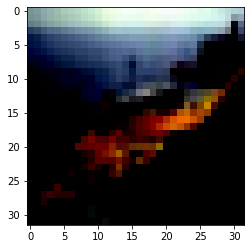

In [282]:

img = img.cpu()
new_img = img[x].numpy()
new_img = new_img.transpose((2, 1, 0))
plt.imshow(new_img, clim = (-1, 1))

(32, 32, 1)


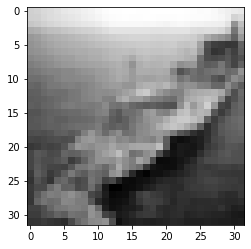

In [283]:
L = L.cpu()
fake_gray = np.array(L[x])
fake_gray = fake_gray.transpose((2, 1, 0))
print(fake_gray.shape)
plt.imshow(fake_gray, cmap = 'gray')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


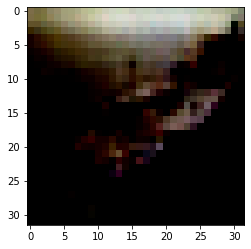

In [284]:
fake = fake.cpu()
fake1 = fake[x].detach().numpy()
fake1 = fake1.transpose((2, 1, 0))
fake1.shape
plt.imshow(fake1)

In [240]:
path = 'E:\\Photos\\'
train_paths = [path+f for f in listdir(path) if isfile(join(path, f))]

data_transform = transforms.Compose([data_load.Normalize(), data_load.ToTensor()])
Color_Dataset_train = data_load.ColorizationDataset(path_list = train_paths, transform=data_transform)


batch_size = 32

test_loader = DataLoader(Color_Dataset_train, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

print('Number of images: ', len(Color_Dataset_train))

for batch_i, data in enumerate(test_loader):
    # get the input images and their corresponding labels
    L = data['L']
    ab = data['ab']
    img = data['image']
        
    #img = img.type(torch.FloatTensor)

    #L = L.type(torch.FloatTensor)

    fake = gen(L)

    if batch_i == 0:
        break


Number of images:  5097


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


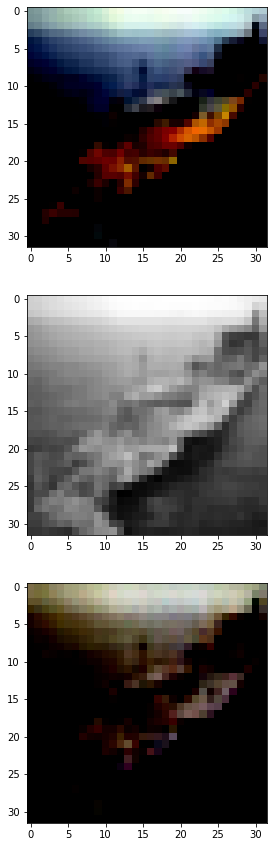

In [285]:
x = 0

img = img.cpu()
new_img = img[x].numpy()

new_img = new_img.transpose((2, 1, 0))

L = L.cpu()
fake_gray = np.array(L[x])
fake_gray = fake_gray.transpose((2, 1, 0))


fake = fake.cpu()
fake1 = fake[x].detach().numpy()
fake1 = fake1.transpose((2, 1, 0))




fig = plt.figure(figsize=(15, 15))
  
# setting values to rows and column variables
rows = 3
columns = 1
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(new_img)

fig.add_subplot(rows, columns, 2)
plt.imshow(fake_gray, cmap = 'gray')

fig.add_subplot(rows, columns, 3)

plt.imshow(fake1)



###### print("Our model: \n\n", gen, '\n')
print("The state dict keys: \n\n", gen.state_dict().keys())

In [17]:
torch.save(gen.state_dict(), 'checkpoint3.pth')

In [49]:
torch.save(gen.state_dict(), os.path.join('E:\\DeepLearning with pytorch\\PyTorch\Colorization\\', 'gen-%d.pkl' % 3))

In [50]:
gen = model.Generator()

gen.load_state_dict(torch.load(os.path.join('E:\\DeepLearning with pytorch\\PyTorch\Colorization\\', 'gen-%d.pkl' % 3)))

<All keys matched successfully>

'export' is not recognized as an internal or external command,
operable program or batch file.
